In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import * #Dense, Flatten, Conv2D, MaxPooling2D 
from keras import losses 
from keras import metrics
from keras import optimizers
from keras import models
from tensorflow.keras import utils
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
(train_img, train_label), (test_img, test_label)=fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
base_conv=VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
train_label=utils.to_categorical(train_label)
test_label=utils.to_categorical(test_label)

In [ ]:
train_img=np.reshape(train_img,(-1, 28, 28,1))
test_img=np.reshape(test_img,(-1, 28,28, 1))

In [ ]:
from keras.layers.merging.concatenate import Concatenate
train_img=Concatenate()([train_img, train_img, train_img])
test_img=Concatenate()([test_img, test_img, test_img])

train_img.shape

TensorShape([60000, 28, 28, 3])

In [ ]:
new_size_train_img=tf.image.resize(train_img, (32, 32))
new_size_test_img=tf.image.resize(test_img, (32, 32))

new_size_train_img.shape, train_img.shape

(TensorShape([60000, 32, 32, 3]), TensorShape([60000, 28, 28, 3]))

In [ ]:
from tensorflow.keras.utils import img_to_array
img_train = np.array([img_to_array(im) for im in new_size_train_img])
img_test=np.array([img_to_array(im) for im in new_size_test_img])

In [ ]:
from sklearn.model_selection import train_test_split
train_img, valid_img, train_label, valid_label = train_test_split(img_train, 
                                                                  train_label,
                                                                  test_size=0.2,
                                                                  random_state=13)

In [ ]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_generator=ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator.fit(train_img)
test_generator.fit(valid_img)

In [ ]:
train_generator = train_generator.flow(train_img, train_label, batch_size=200)
test_generator = test_generator.flow(valid_img, valid_label, batch_size=200)

In [ ]:
test_img.shape

TensorShape([10000, 28, 28, 3])

In [ ]:
base_conv=VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [ ]:
base_conv.trainable=False
trainable_set= True
for layer in base_conv.layers:
  if layer.name == 'block3_conv1':
    trainable_set = True
  if trainable_set:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
from keras import layers
target_size=(150,150)
original_dim=(32,32,3)
model = models.Sequential()
model.add(layers.Input(original_dim))
model.add(layers.Lambda(lambda image:tf.image.resize(image, target_size)))
model.add(base_conv)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer = keras.optimizers.RMSprop(1e-4),
              metrics = ['accuracy'])

In [19]:
from keras.api._v2.keras import callbacks
history = model.fit(train_generator,
                    epochs=5,
                    steps_per_epoch=50,
                    callbacks=[checkpoint],
                    validation_data=test_generator,
                    validation_steps=60,
                    shuffle=True)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 1.6751 - accuracy: 0.4159 
Epoch 1: val_loss improved from inf to 0.86083, saving model to best_weights.hdf5
50/50 [==============================] - 3657s 74s/step - loss: 1.6751 - accuracy: 0.4159 - val_loss: 0.8608 - val_accuracy: 0.7189
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 1.1066 - accuracy: 0.6171 
Epoch 2: val_loss improved from 0.86083 to 0.69867, saving model to best_weights.hdf5
50/50 [==============================] - 3637s 74s/step - loss: 1.1066 - accuracy: 0.6171 - val_loss: 0.6987 - val_accuracy: 0.7449
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.9420 - accuracy: 0.6655 
Epoch 3: val_loss improved from 0.69867 to 0.61523, saving model to best_weights.hdf5
50/50 [==============================] - 3624s 73s/step - loss: 0.9420 - accuracy: 0.6655 - val_loss: 0.6152 - val_accuracy: 0.7778
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0

Text(0.5, 1.0, 'Training and validation accurancy')

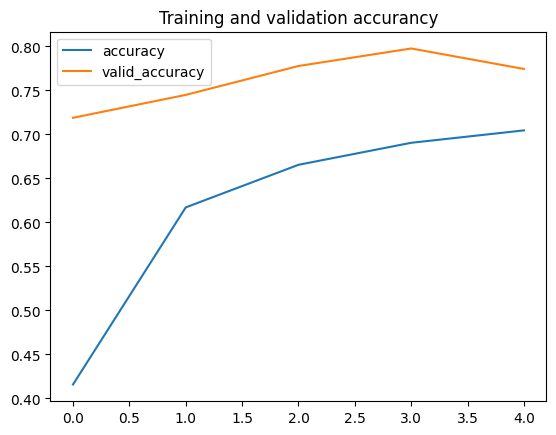

In [24]:
plt.plot(history.history['accuracy'], label ='accuracy')
plt.plot(history.history['val_accuracy'], label='valid_accuracy')
plt.legend()
plt.title("Training and validation accurancy")

Text(0.5, 1.0, 'Training and validation loss')

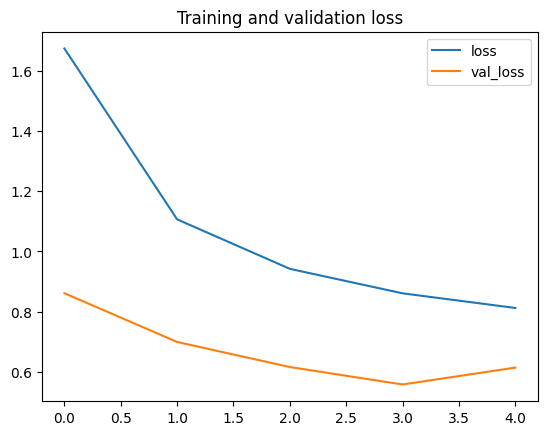

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and validation loss')

In [22]:
test_img=tf.image.resize(test_img,(150,150))

In [28]:
test_generator=ImageDataGenerator(
    rescale=1./255
)
test_generator.fit(test_img)
test_generator=test_generator.flow(
    test_img,
    test_label,
    batch_size=200)

test_loss, test_accuracy = model.evaluate (test_generator, steps=50)
print('test accuracy is: ', test_accuracy)

50/50 [==============================] - 1644s 33s/step - loss: 0.7457 - accuracy: 0.7418
test accuracy is:  0.7418000102043152


In [29]:
model = keras.models.load_model('best_weights.hdf5')

In [ ]:
test_generator=ImageDataGenerator(
    rescale=1./255
)
test_generator.fit(test_img)
test_generator=test_generator.flow(
    test_img,
    test_label,
    batch_size=200)

test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print('test accuracy is: ', test_accuracy)

43/50 [========================>.....] - ETA: 3:49 - loss: 0.6144 - accuracy: 0.7752

# Висновок

Отже, в результаті створення та навчання нейромережі було досягнено результату точності - 77%. 
Даний показник є меншим аніж у згортковій нейромережі без шару VGG16 та мережі повнозв'язного типу, хоча низька точність може залежати від малої кількості епох - 5. Проте навіть з даною кількістю епок дана мережа началась 7 годин, а з більшою кілкістю епох мережа Інтернету перезавантажувалсь і процес не міг бути закінченим. 
Отже, як висоновок можна стверджувати, що раще використовувати мережі або без шару VGG16, або запускати мережу на навчання на сервері зі стабільним з'єднанням. 